In [1]:

import os
import matplotlib.pyplot as plt

from skimage import io
import seaborn as sns
import warnings
import numpy as np
import warnings
import pandas as pd
import seaborn as sns

# best font and style settings for notebook 
warnings.filterwarnings('ignore')
sns.set_style("white")
# mpl.rcParams['font.family'] = 'MiSans'


In [2]:
import pandas as pd
import numpy as np

# 定义表格数据
df_label = {
    "类别编号": [0, 1, 2, 3, 4, 5, 6],
    "类别名称（英文）": ["background", "building", "road", "water", "barren", "forest", "agriculture"],
    "类别名称（中文）": ["背景", "建筑", "道路", "水体", "裸土", "林地", "耕地"],
    "说明": [
        "通常为未分类区域",
        "房屋、厂房等",
        "包括主干道、辅路等",
        "包括河流、湖泊等",
        "裸露土地、沙地等",
        "森林、树木等",
        "农田、种植区域"
    ]
}
# 构造类别编号到 RGB 的映射（索引即为类别编号）
id2color = np.array(
    [
        [0, 0, 0],  # 0 - 背景
        [220, 20, 60],  # 1 - 建筑
        [128, 64, 128],  # 2 - 道路
        [0, 0, 255],  # 3 - 水体
        [210, 180, 140],  # 4 - 裸土
        [34, 139, 34],  # 5 - 林地
        [255, 255, 0],  # 6 - 耕地
    ],
    dtype=np.uint8,
)
df_label = pd.DataFrame(df_label)
df_label

,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
1,1,building,建筑,房屋、厂房等
2,2,road,道路,包括主干道、辅路等
3,3,water,水体,包括河流、湖泊等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等
6,6,agriculture,耕地,农田、种植区域


In [3]:

from infer_all import road_seg, all_seg, overlay_mask_on_image

img_path = "../photo/1173.png"

# ✅ 道路分割模型（只分出 road 类）
road_mask = road_seg(
    image_path=img_path,
    config_path="configs/road_seg/pp_liteseg_stdc1_deepglobe_infer.yml",
    model_path="pp_liteseg_stdc1_deepglobe.pdparams",
    save_dir="../output/test",
)

# ✅ 多类地物分割模型（输出0~6的语义mask）
mask = all_seg(
    image_path=img_path,
    config_path="configs/segmenter/segmenter_rural2.yml",
    model_path="../output/segmenter_rural2/iter_87500/model.pdparams",
    save_dir="../output/test",
)

# ✅ 可选备份一份副本（用于后续处理）
mask_2 = mask.copy()
mask[road_mask == 1] = 2  # 2: road

[🚗] 正在用 PP-LiteSeg 道路模型推理图像：../photo/1173.png
[✅] 成功读取道路分割结果：../output/test\pseudo_color_prediction\1173.png
[🚀] 正在用 PP-LiteSeg 推理图像（多分类）：../photo/1173.png
[✅] 成功读取输出文件：../output/test\pseudo_color_prediction\1173.png


In [4]:
df_label

,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
1,1,building,建筑,房屋、厂房等
2,2,road,道路,包括主干道、辅路等
3,3,water,水体,包括河流、湖泊等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等
6,6,agriculture,耕地,农田、种植区域


In [5]:
mask_val = mask.copy()

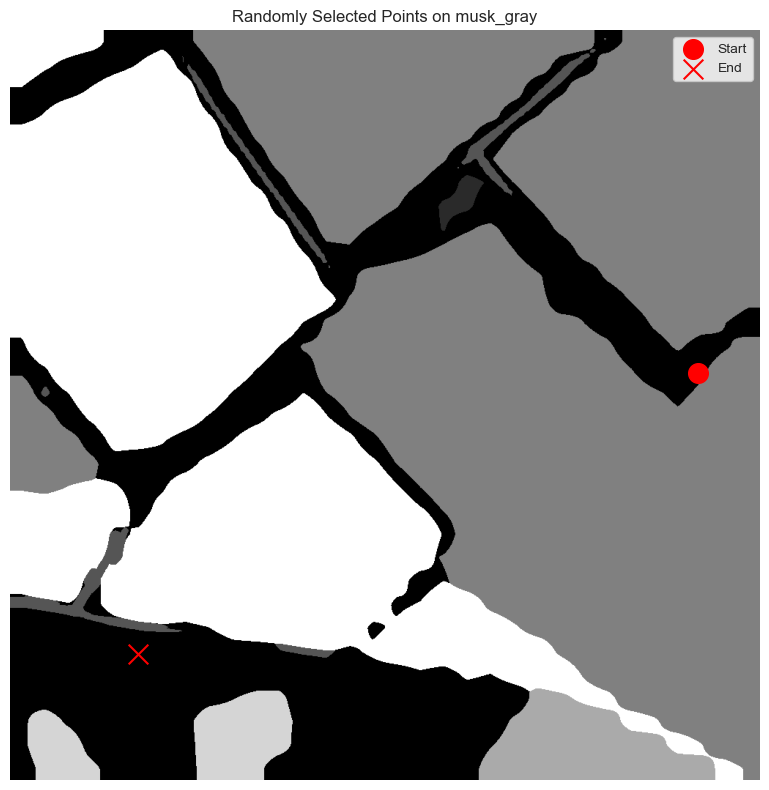

(array([467, 939], dtype=int64), array([851, 175], dtype=int64))

In [6]:
# 随机选两个不同的可通行区域像素点（排除房屋）
passable_values = [0, 2, 4, 5]  # 可通行区域
passable_indices = np.argwhere(np.isin(mask_val, passable_values))

# 随机选择两个点
start_idx, end_idx = passable_indices[
    np.random.choice(len(passable_indices), 2, replace=False)
]

# 可视化
plt.figure(figsize=(8, 8))
plt.imshow(mask_val, cmap="gray")
# 起点圆圈（o）
plt.scatter(start_idx[1], start_idx[0], c="red", marker="o", s=200, label="Start")

# 终点叉号（x）
plt.scatter(end_idx[1], end_idx[0], c="red", marker="x", s=200, label="End")

plt.title("Randomly Selected Points on musk_gray")
plt.legend()
plt.axis("off")
plt.tight_layout()
plt.show()

(start_idx, end_idx)

In [29]:
df_label.iloc[passable_values]

,类别编号,类别名称（英文）,类别名称（中文）,说明
0,0,background,背景,通常为未分类区域
2,2,road,道路,包括主干道、辅路等
4,4,barren,裸土,裸露土地、沙地等
5,5,forest,林地,森林、树木等


In [34]:
from queue import PriorityQueue

cost_map = np.full_like(mask_val, 1e5, dtype=float)  # 默认高代价
cost_map[mask_val == 5] = 50  # 植被、林地
cost_map[mask_val == 2] = 200  # 道路
cost_map[mask_val == 4] = 5  # 裸土


# 房屋 (100) 保持高代价

# ======== 3. A* 搜索 ========
def heuristic(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))


h, w = cost_map.shape
visited = np.zeros((h, w), dtype=bool)
prev_node = np.empty((h, w), dtype=object)
pq = PriorityQueue()
start_tup = tuple(start_idx)
end_tup = tuple(end_idx)
pq.put((heuristic(start_tup, end_tup), 0.0, start_tup))
found = False

while not pq.empty():
    f, g, current = pq.get()
    if visited[current]:
        continue
    visited[current] = True
    if current == end_tup:
        found = True
        break
    x, y = current
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            nx, ny = x + dx, y + dy
            if 0 <= nx < h and 0 <= ny < w and not visited[nx, ny]:
                ng = g + cost_map[nx, ny]
                pq.put((ng + heuristic((nx, ny), end_tup), ng, (nx, ny)))
                if prev_node[nx, ny] is None:
                    prev_node[nx, ny] = (x, y)

# ======== 4. 回溯路径 ========
if not found:
    print("[❌] 未找到从起点到终点的路径！")
    path = []
else:
    path = []
    cur = end_tup
    while cur != start_tup and prev_node[cur] is not None:
        path.append(cur)
        cur = prev_node[cur]
    path.append(start_tup)
    path = path[::-1]
    if path[-1] == end_tup:
        print("[✅] 成功找到从起点到终点的路径！")
    else:
        print("[❌] 回溯路径未正确连接起点与终点！")

print("Path length (pixels):", len(path))

# ======== 5. 可视化路径 ========
# 将 musk_gray 转为 RGB 图像
seg_rgb = np.stack([mask_val] * 3, axis=-1)

# 用绿色 (0,255,0) 将路径标记为粗线
thickness = 2  # 可调节粗细（1 表示1个像素边框，设置为1时采用3x3窗口）
for i, j in path:
    # 对每个路径点，标记周围3x3区域
    for di in range(-thickness, thickness + 1):
        for dj in range(-thickness, thickness + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < h and 0 <= nj < w:
                seg_rgb[ni, nj] = [0, 255, 0]

# ======== 4.5 输出路径矩阵 ========
if path:
    path_array = np.array([[x, y] for (x, y) in path])  # shape (n, 2)
    # print("路径点矩阵 (shape={}):".format(path_array.shape))
    # print(path_array)


[✅] 成功找到从起点到终点的路径！
Path length (pixels): 1320


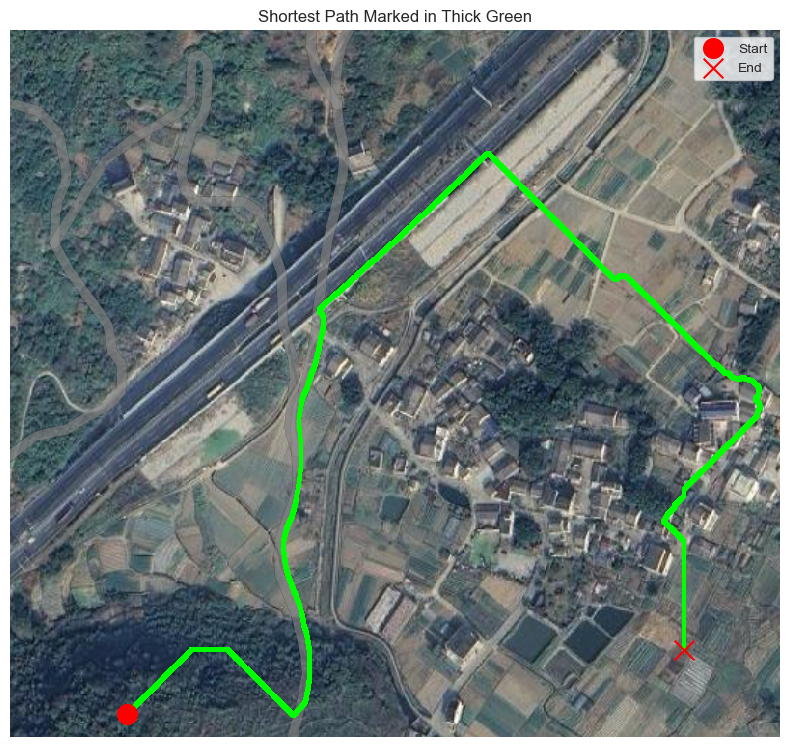

In [35]:
img = io.imread(img_path)  # shape: (H, W, 3)

# === 绘制路径（绿色） ===
overlay = img.copy()[:, :, :3]
path_color = [0, 255, 0]  # RGB 绿色
thickness = 2  # 可调粗细

h, w = overlay.shape[:2]
for i, j in path:
    for di in range(-thickness, thickness + 1):
        for dj in range(-thickness, thickness + 1):
            ni, nj = i + di, j + dj
            if 0 <= ni < h and 0 <= nj < w:
                overlay[ni, nj] = path_color

plt.figure(figsize=(8, 8))
io.imshow(overlay)

# 起点圆圈（o）
plt.scatter(start_idx[1], start_idx[0], c="red", marker="o", s=200, label="Start")

# 终点叉号（x）
plt.scatter(end_idx[1], end_idx[0], c="red", marker="x", s=200, label="End")

plt.title("Shortest Path Marked in Thick Green")

plt.legend()

plt.axis("off")

plt.tight_layout()

# plt.show()

In [40]:
pd.DataFrame(path_array, columns=["x", "y"]).T

,0,1,2,3,4,5,6,7,8,9,...,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319
x,709,708,707,706,705,704,703,702,701,700,...,633,634,635,636,637,638,639,640,641,642
y,121,122,123,124,125,126,127,128,129,130,...,698,698,698,698,698,698,698,698,698,698
